In [68]:
from models import *
from datetime import datetime
from random import random
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os

# Initiate parameters
start_date = "2020-01-01"  #"2018-12-31"  
end_date = '2023-03-12'
ticker = 'hp'
period = "1wk" 
shuffle = True

# Sentiment types... APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment #TwitterSentiment
sentiment = True
sentiment_type = 'TwitterSentiment'
aggr_function = 'median'

#Setup windows
formation_window = 4
target_window = 1

#Split Ratios
split_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

#trade condition
condition = False

# EMA indicators
indicator1 = 5
indicator2 = 8
indicator3 = 21

# training batches
batch_size_train = 6
batch_size_valid = 2

#Clear Folders
delete = True
export_excels = False

#__________________________________________________
# Do not change
api_key = ''
window_size = formation_window + 1

if sentiment == False:
    news_df = None
if sentiment_type == 'TwitterSentiment':
    twitter = True
else:
    twitter = False

excel_reports = ".\Excel reports"
temp = f".\TempFiles\{ticker}"

#Delete folders
if delete == True:
    try:
        shutil.rmtree(excel_reports)
        shutil.rmtree(temp)
    except:
        pass
    # Create folder, if exist pass exception
    try:
        os.mkdir("Excel reports")
        os.mkdir(f"TempFiles\{ticker}")
    except:
        pass

# Print stuffs
print("\nTensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("\nwindow size: ", window_size)
print("formation_window: ", formation_window)
print("target_window: ", target_window)
print("chart period: ", period)



Tensorflow version:  2.9.1
Numpy version:  1.23.1

window size:  5
formation_window:  4
target_window:  1
chart period:  1wk


In [69]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    GetNewsAPI.fit(ticker=ticker, start_date=start_date, end_date=end_date,
                   n_news=1000, token=api_key, offset=0, export_excel=True, twitter=twitter,temp_folder=temp)
    news_df = GetNewsAPI.transform()
news_df.shape


--------> GetNews completed



(260, 2)

In [70]:
from transformers_preprocess import PullData

GetData = PullData()

print("ticker: ",ticker)

GetData.fit(ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            interval=period,  
            progress=False,
            condition=condition,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=indicator1,
            timeperiod2=indicator2,
            timeperiod3=indicator3,
            export_excel=export_excels,
            excel_path=excel_reports,
            listed_conditions=None,
            sentiment=sentiment,
            sentiment_type=sentiment_type, 
            news_df=news_df,
            chart_period=period,
            sentiment_aggr=aggr_function,
            )

data_prep = GetData.transform()

# Validation
if window_size != (formation_window + 1):
    raise Exception(
        f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")

df = data_prep[data_prep['Date']!= "Month"].copy()

# Function to check if date is Monday
def is_monday(date):
    return date.weekday() == 0
# Loop through first 5 rows and check if the date is Monday
for index, row in df.head(10).iterrows():
    date_obj = row['Date'].date()

    if not is_monday(date_obj):
        raise Exception(f"Error: {date_obj} is not Monday.")


ticker:  hp
initial shape:  (176, 6)


In [71]:
data_prep.tail()


,Date,Open,High,Low,Close,EMA5,EMA8,EMA21,TwitterSentiment,trades
162,2023-02-06 00:00:00,45.189999,46.720001,42.730000,45.730000,46.863425,47.258130,46.843814,0.36905,163
163,2023-02-13 00:00:00,44.849998,46.840000,41.770000,42.410000,45.378950,46.180767,46.440740,0.63690,163
164,2023-02-20 00:00:00,41.930000,42.700001,39.430000,41.150002,43.969301,45.062819,45.959764,0.10115,163
165,2023-02-27 00:00:00,41.459999,45.669998,40.900002,44.830002,44.256201,45.011082,45.857058,0.46090,163
0,Month,44.459999,45.110001,39.230000,39.369999,44.256201,45.011082,45.857058,0.46090,163


In [72]:
####################################################################

from transformers_preprocess import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                  export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

data_normalized, Dates = NormalizeData.transform(data_prep)
data_normalized.head(8)
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast
#Dates



Dataframe shape:  (815, 10)
Number of formations:  163
--------> NormalizeData completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,TwitterSentiment,maxv,minv
0,0.742389,0.932970,0.435967,0.809653,0.950835,1.000000,0.948392,0.36905,47.258130,39.230000
1,0.700038,0.947917,0.316388,0.396107,0.765926,0.865802,0.898184,0.63690,47.258130,39.230000
2,0.336318,0.432230,0.024912,0.239159,0.590337,0.726548,0.838273,0.10115,47.258130,39.230000
3,0.277773,0.802179,0.208019,0.697548,0.626074,0.720103,0.825480,0.46090,47.258130,39.230000
4,0.651459,0.732425,0.000000,0.017439,0.626074,0.720103,0.825480,0.46090,47.258130,39.230000
5,0.743175,1.000000,0.299292,0.596562,0.578318,0.425170,0.109200,0.00000,54.450001,44.560001
6,0.401415,0.817998,0.374115,0.622851,0.593162,0.469099,0.155896,0.20230,54.450001,44.560001
7,0.704752,0.704752,0.000000,0.009100,0.398475,0.366877,0.142551,0.13045,54.450001,44.560001


In [73]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment,validation_set=validation_ratio, test_set=test_ratio)

x_train, x_valid, x_test, x_train_x, x_valid_x, x_test_x,_ = SplitData.transform(data_normalized)
# x_train.head(25)



DF Shape:  (815, 10)
train_split split:  570
validation split:  120
total validation windows:  49.0

Split train ratio: 70 %
Split validation ratio: 15 %
Split test ratio: 15 %

train period: 2023-02-06 - 2021-09-13
valid period: 2020-12-21 - 2022-06-13
test period: 2023-01-16 - 2020-12-14

Total Windows:  163.0
x_train windows:  114.0
x_valid windows:  24.0
x_test windows:  25.0
--------> SplitData completed



In [74]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed



In [75]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels_valid = GetTensoredValidDataset.transform(x_valid)
x_test_tensors, labels = GetTensoredValidDataset.transform(x_test)
# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed

--------> GetTensoredDataset completed



<b>Model Training</b>

In [76]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

datetime_ = datetime.today().date()
number = int(random()*10000)
model_name_ = f'{ticker}_model_{datetime_}_{number}.h5'
model_name = f'{temp}/{model_name_}'

metric = 'loss'
early_stopping = EarlyStopping(
    monitor=metric, patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=0)

model_checkpoint = ModelCheckpoint(monitor=metric,
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Bellow code is used to find the best model architecture, recommended to use cloud computing

In [77]:
# from testing import get_models,optimize
# from datetime import datetime
# start_time = datetime.now().strftime("%H:%M:%S")
# start = datetime.now()
# print("Training started at ",start_time)
# tf.random.set_seed(7788)
# np.random.seed(7788)

# # #Permutation testing
# # num_layers = 2
# # min, max = 2, 4
# # node_step_size = 2
# # node_options = list(range(min, max + 1, node_step_size))
# # two_layer_possibilities = [node_options, node_options]
# # layer_node_permutations  = list(itertools.product(*two_layer_possibilities))

# f_df = pd.DataFrame()

# for layer in range(5,6):
#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("\n------ > Layer: ",layer)
#     print("Layer loop started: ",progress_time)

#     all_models, names = get_models(num_layers=layer, min=2, max=4, node_step_size=2, features=x_train.shape[1])

#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("Models: ",len(all_models))
#     print("Models constructed: ",progress_time)
    
#     optimizing_df = optimize(models=all_models,X_train=x_train_tensors,X_valid=x_valid_tensors,X_test=x_valid,labels=labels_valid,epochs=1000,verbose=0,window_size=window_size,callbacks=callbacks,layer=layer,ticker=ticker,excel_path=tested_models)
# # optimizing_df
#     f_df = f_df.append(optimizing_df)
#     f_df.to_excel('test.xlsx')
# end_time = datetime.now().strftime("%H:%M:%S")
# end = datetime.now()
# print("\nTraining ended at ",end_time) 
# print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")

Get Model

In [78]:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
start = datetime.now()
print("Training started at ",start_time)

tf.random.set_seed(7788)
np.random.seed(7788)
features = x_train.shape[1]

print(f"Model training - {str.upper(ticker)} \n")

def general_model(features: int):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=1, kernel_size=10,
                               strides=1, padding="same",
                               activation=tf.nn.selu,
                               input_shape=[None, features]),

        tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(3, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
        tf.keras.layers.Dense(4, activation=tf.nn.selu),
        tf.keras.layers.Dense(3, activation=tf.nn.selu),
        tf.keras.layers.Dense(2, activation=tf.nn.selu),
        tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    return model


model = general_model(features)


optimizer2 = tf.keras.optimizers.Adam(
            learning_rate=0.00007, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.0006, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer2
              )

model.fit(x_train_tensors, epochs=1000, callbacks=[callbacks], validation_data=x_valid_tensors,verbose=1)


end_time = datetime.now().strftime("%H:%M:%S")
end = datetime.now()
print("\nTraining ended at ",end_time) 
print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")



Training started at  22:56:22
Model training - HP 

Epoch 1/1000
19/19 [==============================] - 19s 246ms/step - loss: 0.4638 - val_loss: 0.4644 - lr: 7.0000e-05
Epoch 2/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.4072 - val_loss: 0.4074 - lr: 7.0000e-05
Epoch 3/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.3560 - val_loss: 0.3590 - lr: 7.0000e-05
Epoch 4/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.3124 - val_loss: 0.3179 - lr: 7.0000e-05
Epoch 5/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.2757 - val_loss: 0.2833 - lr: 7.0000e-05
Epoch 6/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.2447 - val_loss: 0.2539 - lr: 7.0000e-05
Epoch 7/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.2186 - val_loss: 0.2289 - lr: 7.0000e-05
Epoch 8/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1965 - val_loss: 0.2075 - lr: 7.0000e-05
Ep

In [79]:
from functions import model_forecast
import time

forecast = model_forecast(model, x_test, window_size=window_size, debug=False)

from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_test=x_test, x_test_x=x_test_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()

time.sleep(3) 

from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_test=x_test,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)



25/25 [==============================] - 6s 48ms/step
--------> ReverseNormalization completed

--------> GetFinalDataframe



In [82]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

acceptance = 0
penalization = 0

GetModelPerformance.fit(acceptance=acceptance,
                        penalization=penalization,
                        entry_candle='Current Open',#Current Open
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df = trades_df.sort_values('Datetime',ascending=True)

#trades_df.tail(16)


ticker: HP

Formations:  25
period: 2023-01-16 - 2020-12-14
Entry Candle:  Current Open

Total Trades:  21
Profit Trades:  18
Loss Trades:  3

Win Ratio: 86.0 %
Loss Ratio: 14 %

Trade nr with exact TP:  13
Ratio of exact TP: 61.9 %

Average profit per trade:  600

Gross profit:  12595
Gross loss:  -2273

Net profit:  10322


In [83]:
trades_df[trades_df['profit']<0]

,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,51.020000,51.250000,46.130001,46.919998,48.110313,48.128854,46.908286,nn,nn,0.14635,2023-01-16,-2.439999,1
1,47.139999,50.349998,46.090000,49.189999,48.470208,48.364664,47.115715,nn,nn,0.63690,2023-01-23,-2.439999,1
2,48.169998,49.779999,44.910000,45.349998,47.430138,47.694738,46.955195,nn,nn,0.00000,2023-01-30,-2.439999,1
3,45.189999,46.720001,42.730000,45.730000,46.863425,47.258130,46.843814,nn,nn,0.36905,2023-02-06,-2.439999,1
4,44.849998,46.840000,41.770000,42.410000,48.470208,48.364664,47.115715,46.84,47.583185,0.00000,2023-02-07,-2.439999,1
70,32.700001,33.700001,31.809999,32.410000,30.041425,28.714297,25.202848,nn,nn,0.00000,2021-03-08,-2.530001,13
71,32.400002,32.750000,29.590000,30.670000,30.250950,29.148897,25.699862,nn,nn,0.00000,2021-03-15,-2.530001,13
72,30.719999,30.770000,26.080000,28.459999,29.653967,28.995809,25.950783,nn,nn,0.00000,2021-03-22,-2.530001,13
73,28.020000,28.450001,26.760000,28.440001,29.249311,28.872296,26.177076,nn,nn,0.00000,2021-03-29,-2.530001,13


In [84]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
df = trades_df.head(3)


Trade:  1
Window size:  5
Period: 2023-01-16 - 2023-02-06

Budget:  10000

Entry price:  44.85
Label (target):  46.84
Model prediction:  47.58
Market Change: -2.44 $
Profit: -544.04 $


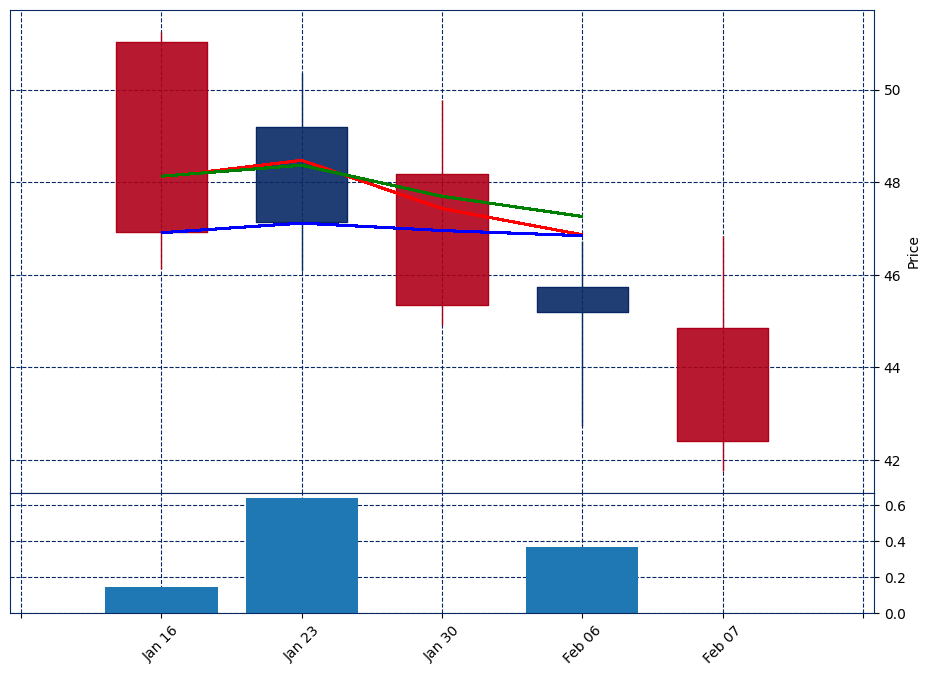

,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,51.020000,51.250000,46.130001,46.919998,48.110313,48.128854,46.908286,nn,nn,0.14635,2023-01-16,-2.439999,1
1,47.139999,50.349998,46.090000,49.189999,48.470208,48.364664,47.115715,nn,nn,0.63690,2023-01-23,-2.439999,1
2,48.169998,49.779999,44.910000,45.349998,47.430138,47.694738,46.955195,nn,nn,0.00000,2023-01-30,-2.439999,1
3,45.189999,46.720001,42.730000,45.730000,46.863425,47.258130,46.843814,nn,nn,0.36905,2023-02-06,-2.439999,1
4,44.849998,46.840000,41.770000,42.410000,48.470208,48.364664,47.115715,46.84,47.583185,0.00000,2023-02-07,-2.439999,1


In [85]:
#trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,
budget=budget,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
trade += 1
df


In [86]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle=entry_candle,#"Current Open"
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final = trades_df_final.sort_values('Datetime', ascending=True)
trades_df_final.tail(5)

--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,TwitterSentiment,Datetime,profit,trade,Entry,Performance
0,51.020000,51.250000,46.130001,46.919998,48.110313,48.128854,46.908286,nn,nn,0.14635,2023-01-16,-2.439999,1,nn,nn
1,47.139999,50.349998,46.090000,49.189999,48.470208,48.364664,47.115715,nn,nn,0.63690,2023-01-23,-2.439999,1,nn,nn
2,48.169998,49.779999,44.910000,45.349998,47.430138,47.694738,46.955195,nn,nn,0.00000,2023-01-30,-2.439999,1,nn,nn
3,45.189999,46.720001,42.730000,45.730000,46.863425,47.258130,46.843814,nn,nn,0.36905,2023-02-06,-2.439999,1,nn,nn
4,44.849998,46.840000,41.770000,42.410000,48.470208,48.364664,47.115715,46.84,47.583185,0.00000,2023-02-07,-2.439999,1,44.849998,-544.0


<b>Plot Chart With Labels and Predictions</b>

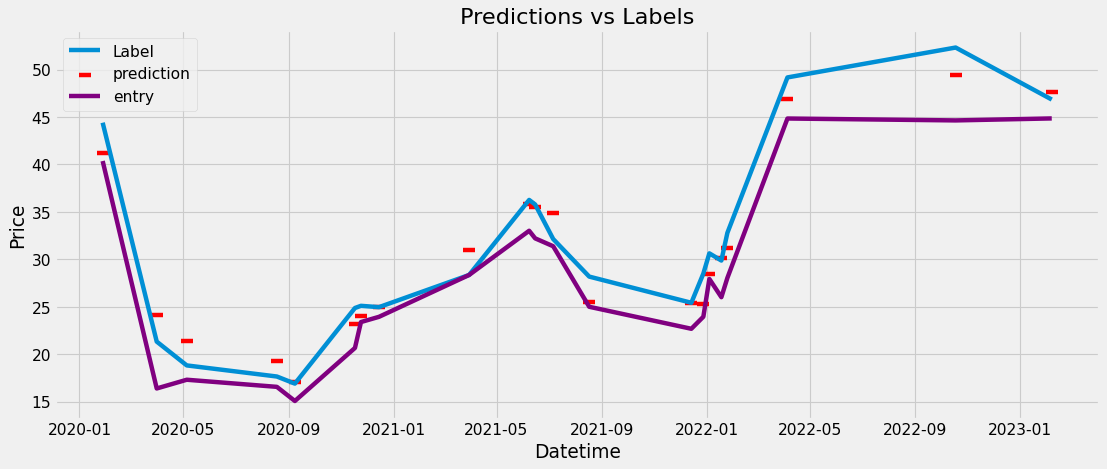

In [87]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(15, 6), dpi=80)

df_plot = trades_df_final[['Datetime','labels','prediction','Entry']]
df_plot = df_plot[df_plot.labels != 'nn']

x1 = df_plot['labels']
x2 = df_plot['prediction']
entry = df_plot['Entry']
y = df_plot['Datetime']

# plot lines
plt.plot(y, x1, label = "Label") #,s=200,marker='*'
plt.scatter(y, x2, label = "prediction",color='red', s=100,marker='_')
plt.plot(y, entry, label = "entry",color='purple')#,color='blue', s=100,marker=0
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Predictions vs Labels')
plt.legend()
plt.show()

<b>Export dataframe with all variables</b>

In [88]:

def ExportFile():
    today = datetime.today().date()

    variables_dict = \
    {
    'model_name':[model_name_],
    'Date':[today],
    'ticker':[ticker],
    'period':[period],
    'api_key':[api_key],
    'sentiment':[sentiment],
    'sentiment_type':[sentiment_type],
    'aggr_function':[aggr_function],
    'formation_window':[formation_window],
    'target_window':[target_window],
    'split_ratio':[split_ratio],
    'test_ratio':[test_ratio],
    'validation_ratio':[validation_ratio],
    'condition':[condition],
    'indicator1':[indicator1],
    'indicator2':[indicator2],
    'indicator3':[indicator3],
    'window_size':[window_size],
    'formation_window':[formation_window],
    'twitter':[twitter],
    'start_date':[start_date],
    'end_date':[end_date],
    'batch_size_train':[batch_size_train],
    'batch_size_valid':[batch_size_valid],
    'shuffle':[shuffle],
    'entry_candle':[entry_candle],
    'excel_reports':[excel_reports],
    'acceptance':[acceptance],
    'penalization':[penalization],
    }

    x_test.to_csv(f'{temp}/{ticker}_test_data.csv')
    x_test_x.to_csv(f'{temp}/{ticker}_x_test_x.csv')
    test_start = len(Dates)-x_test.shape[0]
    Dates_test = Dates[test_start:]
    Dates_test.to_csv(f'{temp}/{ticker}_dates_test.csv')
    Dates.to_csv(f'{temp}/{ticker}_Dates.csv')
    df = pd.DataFrame(variables_dict).transpose()
    df.to_csv(f'{temp}/variables_df.csv')
    return df

df = ExportFile()
df


,0
model_name,hp_model_2023-03-21_2886.h5
Date,2023-03-21
ticker,hp
period,1wk
api_key,631505e804ec58.42743136
sentiment,True
sentiment_type,TwitterSentiment
aggr_function,median
formation_window,4
target_window,1


In [92]:
from final_evaluation import MakeSinglePrediction


MakeSinglePrediction = MakeSinglePrediction()
print('penalization: ',penalization)
print('acceptance: ',acceptance)
fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date=start_date,
                        end_date="2023-03-18",
                        interval=period, #1wk
                        progress=False,
                        condition=condition,
                        timeperiod1=indicator1,
                        timeperiod2=indicator2,
                        timeperiod3=indicator3,
                        debug=False,
                        budget=10000,
                        penalization=penalization,
                        acceptance=acceptance,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type=sentiment_type,
                        sentiment_aggr=aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.tail(formation_window)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

#final_trade_formation.tail()


penalization:  0
acceptance:  0


,Date,Open,High,Low,Close,EMA5,EMA8,EMA21,TwitterSentiment
1,2023-02-20,41.930000,42.700001,39.430000,41.150002,43.969301,45.062819,45.959764,0.004357
2,2023-02-27,41.459999,45.669998,40.900002,44.830002,44.256201,45.011082,45.857058,0.158317
3,2023-03-06,44.459999,45.110001,39.230000,39.369999,42.627467,43.757508,45.267325,0.046675
4,2023-03-13,37.799999,38.529999,33.540001,34.169998,39.808311,41.626950,44.258477,0.092725



Ticker:  hp
1/1 [==============================] - 3s 3s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  34.17
Prediction:  36.4
Expected Market move:  2.23
Expected Profit:  654.18


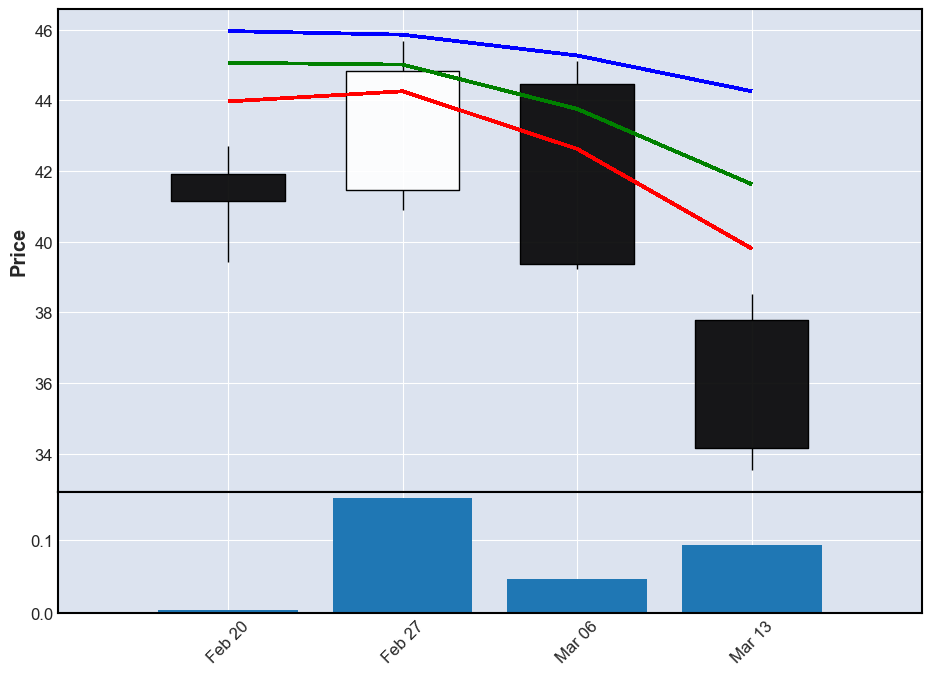

In [93]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
